# BGS Archetypes

The goal of this notebook is to derive a set of spectral archetypes from the BGS template set using Guangtun Zhu's [SetCoverPy](https://github.com/guangtunbenzhu/SetCoverPy) algorithm.

Below, we also choose a single canonical BGS template (located in the green valley) to use in the [https://github.com/desihub/surveysim](surveysim) S/N estimates.

In [14]:
import os
import sys
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [15]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

In [55]:
from desisim.archetypes import compute_chi2
from SetCoverPy import setcover

In [17]:
mpl.rcParams.update({'font.size': 16})
%matplotlib inline

#### Initialize the random seed so the results are reproducible, below.

In [18]:
seed = 123
rand = np.random.RandomState(seed)

### Read the BGS basis templates.
Read the full set of templates sampled to the (rest-frame) optical wavelength range (3500-10000 A) at nominal pixel spacing (0.2 A/pix) and to a fiducial r-band magnitude of 18 and velocity dispersion 100 km/s.

In [19]:
def _build_templates(args):
    """Filler function for the multiprocessing."""
    build_templates(*args)

In [56]:
def build_templates(bgs, input_meta, verbose=False):
    flux, _, meta = bgs.make_templates(input_meta=input_meta, novdisp=True,
                                          nocolorcuts=True, verbose=verbose)
    return [flux.astype('f4'), meta]

In [57]:
def read_and_normalize(verbose=False):
    """Read the basis templates (already in the rest-frame), normalize them 
    to the median flux around 5500-5550 A and plot a handful.
    
    """
    from astropy.table import vstack
    from desisim.templates import BGS
    from desisim.io import empty_metatable
    
    minwave, maxwave = 3500, 1e4 # [Angstrom]
    nominal_rmag = 18.0   # [AB mag]
    nominal_vdisp = 100.0 # [km/s]
    
    bgs = BGS(minwave=minwave, maxwave=maxwave)
    bgs.normline = None # no emission line
    
    nspec = len(bgs.basemeta)
    print('Hack!!!')
    nspec = 100
    
    input_meta = empty_metatable(nmodel=nspec, objtype='BGS')
    input_meta['TEMPLATEID'] = np.arange(nspec)
    input_meta['REDSHIFT'] = 0.0
    input_meta['MAG'] = nominal_rmag
    input_meta['VDISP'] = nominal_vdisp
    input_meta['SEED'] = rand.randint(2**32, size=nspec)
    
    if False: # Not sure why this isn't working correctly --
        chunk = np.array_split(np.arange(nspec), nproc)
    
        tempargs = list()
        for ii in range(nproc):
            tempargs.append((bgs, input_meta[chunk[ii]], verbose))
    
        if nproc > 1:
            pool = multiprocessing.Pool(nproc)
            out = pool.map(_build_templates, tempargs)
            flux = np.vstack(out[0])
            meta = vstack(out[1])
            del out
        else:
            flux, meta = build_templates(bgs, input_meta, verbose)
    else:
        flux, meta = build_templates(bgs, input_meta, verbose)

    nspec, npix = flux.shape
    print('Generated {} rest-frame BGS spectra with {} pixels.'.format(nspec, npix))
    
    return flux, bgs.wave, meta

In [58]:
%time flux, wave, meta = read_and_normalize(verbose=True)
nspec, npix = flux.shape

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
Hack!!!
Generated 100 rest-frame BGS spectra with 32501 pixels.
CPU times: user 2.29 s, sys: 61.5 ms, total: 2.35 s
Wall time: 2.37 s


In [49]:
def plot_subset(nplot=25, ncol=5):
    """Plot a random sampling of the basis templates."""
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot)
    fig, ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow), sharey=True, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :])
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

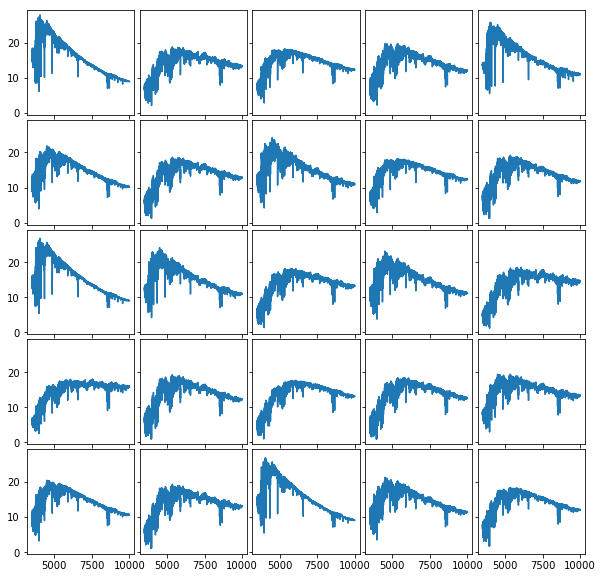

In [50]:
plot_subset()

### Compute the NxN chi2 matrix.

We use chi2 as the "distance" matrix for the Set Cover problem.  

Then, we need to determine what threshold chi2 value differentiates "different" templates.  

Note that the threshold chi^2 value can be tuned until the desired number of archetypes is achieved.  However, If we want the archetypes to describe each spectrum in the parent sample to a precision of prec=0.1 (10%) then we we should set chi2min to be approximately npix*prec^2.

In [63]:
def junk_compute_chi2():
    """Use chi2 [NxN] as the distance matrix.
    
    """
    from SetCoverPy import mathutils    
    
    ferr = np.ones_like(flux)
    
    chi2 = np.zeros((nspec, nspec))
    amp = np.zeros((nspec, nspec))
    for ii in range(nspec):
        if ii % 500 == 0 or ii == 0:
            print('Computing chi2 matrix for spectra {}-{} out of {}.'.format(
                ii*500, np.min(((ii+1)*500, nspec)), nspec))
        xx = flux[ii, :].reshape(1, npix)
        xxerr = ferr[ii, :].reshape(1, npix)
        amp1, chi21 = mathutils.quick_amplitude(xx, flux, xxerr, ferr)
        chi2[ii, :] = chi21
        amp[ii, :] = amp1
    
    return chi2, amp

In [64]:
%time chi2, amp = compute_chi2()

Computing chi2 matrix for spectra 0-100 out of 100.
CPU times: user 13.1 s, sys: 6.92 s, total: 20 s
Wall time: 20.1 s


In [92]:
prec = 0.1
chi2min_nominal = npix*prec**2
print(chi2min_nominal, np.log10(chi2min_nominal)) # seems high...

325.01000000000005 2.51189672368


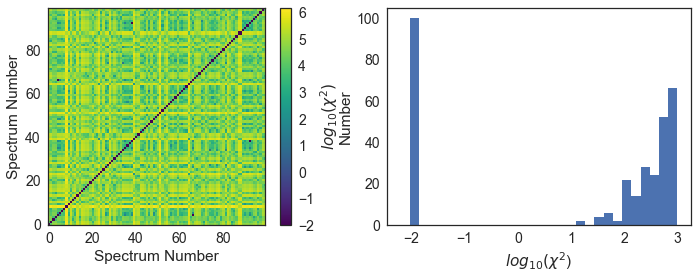

In [70]:
_chi2 = chi2
_chi2[chi2 == 0] = 0.01
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
im = ax[0].imshow(np.log10(_chi2), origin='lower', interpolation='nearest', 
                  vmin=-2.0, cmap='viridis')
ax[0].set_xlabel('Spectrum Number')
ax[0].set_ylabel('Spectrum Number')
plt.colorbar(im, label='$log_{10}(\chi^{2})$', ax=ax[0])

_ = ax[1].hist(np.log10(_chi2).reshape(nspec * nspec), bins=30, range=(-2.2,3))
ax[1].set_ylabel('Number')
ax[1].set_xlabel('$log_{10}(\chi^{2}$)')

### Compute and plot the number of archetypes vs chi2 threshold.

In [88]:
def narch_vs_chi2min():
    """Determine the number of archtypes vs chi2 threshold.
    
    """
    cost = np.ones(nspec) # uniform cost
    chi2min = np.logspace(1, 4, 10)
    print(chi2min)
    narch = np.zeros_like(chi2min)
    for ii, cmin in enumerate(chi2min):
        gg = setcover.SetCover((chi2 <= cmin)*1, cost)
        sol, time = gg.SolveSCP()
        narch[ii] = len(np.nonzero(gg.s)[0])
        
    return narch, chi2min

In [95]:
def qa_narch_vs_chi2min():
    fig, ax = plt.subplots()
    ax.scatter(np.log10(chi2min), narch)
    ax.set_xlabel('$log_{10}(\chi^{2})$ Threshold')
    ax.set_ylabel('Number of Archetypes')
    ax.axvline(x=np.log10(chi2min_nominal), color='red', ls='-')
    ax.grid(True)

In [90]:
narch, chi2min = narch_vs_chi2min()

[    10.             21.5443469      46.41588834    100.            215.443469
    464.15888336   1000.           2154.43469003   4641.58883361  10000.        ]
This Best solution: UB=97.0, LB=96.9999999708106, UB1=97.0, LB1=96.9999999708106
Current Best Solution: UB=97.0, LB=96.9999999708106, change=3.009215877626179e-08% @ niters=0
Current Best Solution: UB=97.0, LB=96.9999999708106, change=3.009215877626179e-08% @ niters=1
Final Best solution: 97.0
Took 0.002 minutes to reach current solution.
This Best solution: UB=96.0, LB=95.99999992301278, UB1=96.0, LB1=95.99999992301278
Current Best Solution: UB=96.0, LB=95.99999992301278, change=8.01950209942485e-08% @ niters=0
Current Best Solution: UB=96.0, LB=95.99999992301278, change=8.01950209942485e-08% @ niters=1
Final Best solution: 96.0
Took 0.002 minutes to reach current solution.
This Best solution: UB=94.0, LB=93.99999999550494, UB1=94.0, LB1=93.99999999550494
Current Best Solution: UB=94.0, LB=93.99999999550494, change=4.781982847

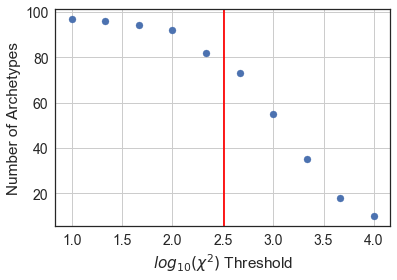

In [96]:
qa_narch_vs_chi2min()

### Choose a chi2 threshold value then get the final set of archetypes.

In [101]:
chi2_thresh = 10**3.5
print('Choosing a log10(chi2) threshold value of {:.1f}.'.format(np.log10(chi2_thresh)))

Choosing a log10(chi2) threshold value of 3.5.


In [97]:
def junk_responsibility(iarch, a_matrix):
    '''Simple method to get the responsibility of each archetype.  Basically, the responsibility 
    is the number of templates described by each archetype.
    
    Args
      iarch : indices of the archetypes
      a_matrix : distance matrix
    Returns 
      resp : responsibility of each archetype (number of objects represented by each archetype)
      respindx : list containing the indices of the parent objects represented by each archetype
      
    '''
    narch = len(iarch)
    resp = np.zeros(narch).astype('int16')
    respindx = []
    for ii, this in enumerate(iarch):
        respindx.append(np.where(a_matrix[:, this] == 1)[0])
        resp[ii] = np.count_nonzero(a_matrix[:, this])
        
    return resp, np.array(respindx)

In [117]:
def junk_get_archetypes():
    """Get the final set of archetypes (and their responsibility, sorted by D4000)
    by solving the SCP problem.
    
    """
    cost = np.ones(nspec) # uniform cost
    a_matrix = (chi2 <= chi2_thresh) * 1
    gg = setcover.SetCover(a_matrix, cost)
    sol, time = gg.SolveSCP()
    
    iarch = np.nonzero(gg.s)[0]
    iarch = iarch[np.argsort(meta['D4000'][iarch])]
    nnarch = len(iarch)
    resp, respindx = responsibility(iarch, a_matrix)

    return iarch, resp, respindx

In [113]:
iarch, resp, respindx = get_archetypes()

This Best solution: UB=27.0, LB=-0.18166938796337817, UB1=27.0, LB1=-0.18166938796337817
Current Best Solution: UB=27.0, LB=-0.18166938796337817, change=100.67284958504953% @ niters=0
Current Best Solution: UB=25.0, LB=24.993524822082023, change=0.02590071167190899% @ niters=2
Final Best solution: 25.0
Took 0.015 minutes to reach current solution.
[ 8 51 54 13 23 17 10 28 72 16 19 22 18 98 11 67  0 33 94  1 85 44 78  9 63]


### Generate some QAplots.

In [127]:
def qa_colorcolor():
    """Generate a color-color plot with the symbol size scaled by the responsibility.
    
    """
    gr = -2.5 * np.log10(meta['FLUX_G'] / meta['FLUX_R'])
    rz = -2.5 * np.log10(meta['FLUX_R'] / meta['FLUX_Z'])
    d4000 = meta['D4000']

    size = 150*(1+(resp - resp.min()) / resp.ptp())
    shade = (d4000[iarch] - d4000[iarch].min()) / d4000[iarch].ptp()
    col = plt.cm.coolwarm(shade)
    for dd1, gr1, rz1, r1, sz in zip(d4000[iarch], gr[iarch], rz[iarch], resp, size):
        print(dd1, gr1, rz1, r1, sz)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.scatter(rz, gr, s=30, c='lightgray', edgecolor=None)
    ax1.scatter(rz[iarch], gr[iarch], c=col, marker='o', s=size, alpha=0.75)
    ax1.set_xlabel('r - z')
    ax1.set_ylabel('g - r')
    ax1.grid(True)

    ax2.scatter(d4000[iarch], resp, s=30, facecolor='lightgray', edgecolor=None)
    #ax2.scatter(d4000[iarch], gr[iarch], c=col, marker='o', s=size, alpha=0.75)
    ax2.set_xlabel('$D_{n}(4000)$')
    ax2.set_ylabel('$log_{10}$ EW([O II] ($\AA$)')
    ax2.grid(True)

    fig.subplots_adjust(wspace=0.3)

In [125]:
def qa_archetypes():
    """Plot the archetypes.  Are some of them too similar...?"""
    nrow, ncol = (4, 4)
    nplot = nrow * ncol
    fig, ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow), sharey=True, sharex=True)
    for thisax, indx, rindx, rr in zip(ax.flat, iarch, respindx, resp):
        for ii in rindx:
            thisax.plot(wave, flux[ii, :], color='gray')
        thisax.plot(wave, flux[indx, :], alpha=0.3)
        thisax.xaxis.set_major_locator(plt.MaxNLocator(2))
        thisax.text(0.95, 0.93, 'ID{:02d}\nResp={}'.format(indx, rr), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)    

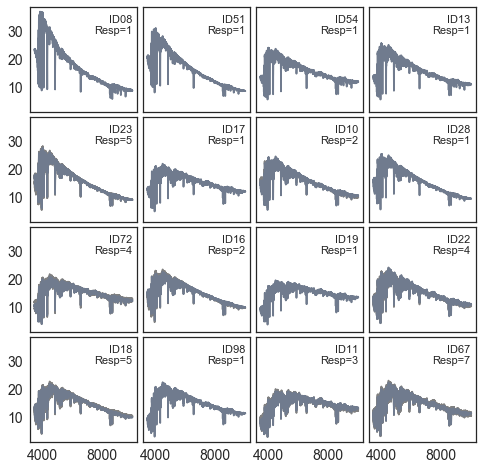

In [126]:
qa_archetypes()

In [128]:
from desisim.io import read_basis_templates
flux, wave, meta = read_basis_templates('BGS')

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


In [149]:
Mr = meta['SDSS_UGRIZ_ABSMAG_Z01'][:, 2]
gr = meta['SDSS_UGRIZ_ABSMAG_Z01'][:, 1]-meta['SDSS_UGRIZ_ABSMAG_Z01'][:, 2]
D4000 = meta['D4000']
indx = (Mr > -21) * (Mr < -20.5) * (gr < 0.9) * (gr > 0.7) * (D4000 > 1.35) * (D4000 < 1.5)
print(np.count_nonzero(indx))
print(np.where(indx)[0])

209
[   3    6   14   79   94  147  226  317  353  374  440  447  464  488  508
  509  534  541  687  790  808  876  889  891 1061 1161 1205 1214 1323 1344
 1360 1368 1378 1379 1389 1392 1432 1478 1518 1554 1564 1579 1594 1607 1624
 1657 1685 1699 1719 1778 1808 1899 1905 1909 1956 1979 2049 2128 2167 2234
 2266 2291 2471 2487 2523 2534 2542 2549 2605 2708 2723 2726 2731 2742 2746
 2757 2827 2844 2848 2871 2919 2951 2986 3050 3093 3096 3141 3184 3185 3254
 3258 3270 3309 3327 3331 3359 3372 3449 3526 3548 3599 3640 3734 3738 3807
 3829 3838 3958 3970 3989 4091 4155 4185 4252 4262 4279 4336 4392 4434 4459
 4482 4649 4670 4681 4690 4703 4753 4760 4809 4822 4827 4867 4902 4982 5006
 5023 5032 5045 5077 5078 5081 5133 5148 5154 5157 5173 5215 5271 5280 5328
 5400 5408 5418 5432 5565 5627 5734 5774 5813 5824 5875 5915 5925 5985 6039
 6192 6312 6365 6380 6382 6430 6440 6495 6569 6572 6575 6610 6635 6655 6922
 6991 7002 7126 7138 7157 7184 7215 7224 7236 7249 7286 7293 7316 7322 7325
 7343 73

(0, 1.2)

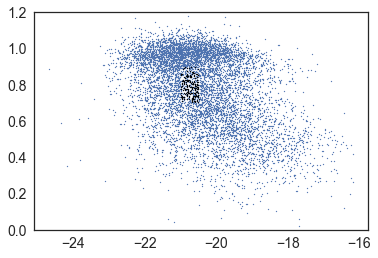

In [146]:
plt.scatter(Mr, gr, s=1)
plt.scatter(Mr[indx], gr[indx], s=1, color='k')
plt.ylim(0, 1.2)

In [150]:
from desisim.io import empty_metatable
from desisim.templates import BGS
    
minwave, maxwave = 3500, 1e4 # [Angstrom]
nominal_rmag = 18.0   # [AB mag]
nominal_vdisp = 100.0 # [km/s]
    
bgs = BGS(minwave=minwave, maxwave=maxwave)
bgs.normline = None # no emission lines
    
input_meta = empty_metatable(nmodel=1, objtype='BGS')
input_meta['TEMPLATEID'] = 3449
input_meta['REDSHIFT'] = 0.0
input_meta['MAG'] = nominal_rmag
input_meta['VDISP'] = nominal_vdisp
input_meta['SEED'] = 1
    
flux, wave, meta = bgs.make_templates(input_meta=input_meta)

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
DEBUG:templates.py:359:_blurmatrix: Populating blur matrix with 1 unique velocity dispersion values.
